In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-06 18:04:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.217.7.240, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2021-03-06 18:04:12 (142 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



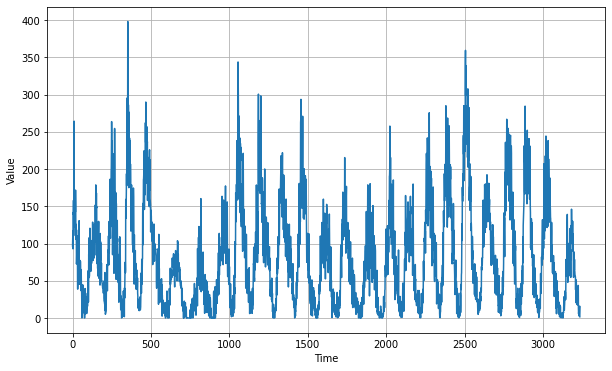

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

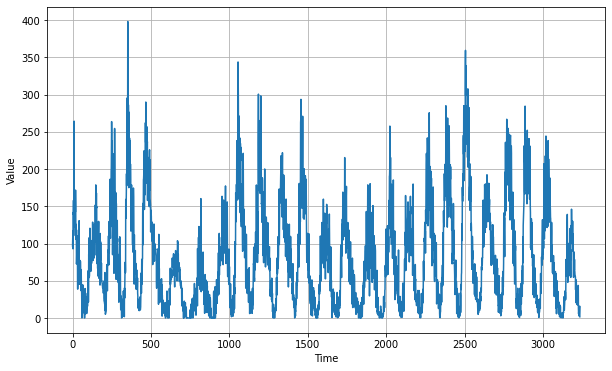

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2700
split_time_v = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_train_v = time[split_time:split_time_v]
x_train_v = series[split_time:split_time_v]

time_valid = time[split_time_v:]
x_valid = series[split_time_v:]

window_size = 50
batch_size = 250
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:


tf.keras.backend.clear_session()

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras


tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)


model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2700,)
Epoch 1/150
11/11 [==============================] - 34s 44ms/step - loss: 82.2363 - mae: 82.7305
Epoch 2/150
11/11 [==============================] - 0s 25ms/step - loss: 82.8096 - mae: 83.3042
Epoch 3/150
11/11 [==============================] - 0s 23ms/step - loss: 83.1098 - mae: 83.6038
Epoch 4/150
11/11 [==============================] - 0s 22ms/step - loss: 82.1974 - mae: 82.6922
Epoch 5/150
11/11 [==============================] - 0s 23ms/step - loss: 82.0369 - mae: 82.5313
Epoch 6/150
11/11 [==============================] - 0s 24ms/step - loss: 82.2181 - mae: 82.7124
Epoch 7/150
11/11 [==============================] - 0s 24ms/step - loss: 82.6465 - mae: 83.1408
Epoch 8/150
11/11 [==============================] - 0s 24ms/step - loss: 82.4975 - mae: 82.9923
Epoch 9/150
11/11 [==============================] - 0s 23ms/step - loss: 82.5642 - mae: 83.0586
Epoch 10/150
11/11 [====

In [11]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

print(minmax(history.history["lr"]))
print(minmax(history.history["loss"]))

(1e-08, 0.2818383)
(17.339468002319336, 84.61614227294922)


(1e-08, 0.3018383, 17.0, 107.0)

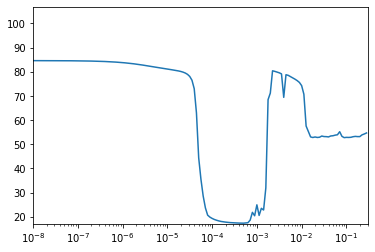

In [12]:
#updated_loss=history.history["loss"]*400
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-08, 0.3018383 , 17, 107])


In [13]:
"""
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LayerNormalization(epsilon=1e-6),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  
  #tf.keras.layers.LSTM(256, return_sequences=True),                    
  #tf.keras.layers.LSTM(128, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)
"""

'\nimport tensorflow as tf\nimport numpy as np\n\n\ntf.keras.backend.clear_session()\ntf.random.set_seed(51)\nnp.random.seed(51)\ntrain_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Conv1D(filters=60, kernel_size=5,\n                      strides=1, padding="causal",\n                      activation="relu",\n                      input_shape=[None, 1]),\n  tf.keras.layers.LayerNormalization(epsilon=1e-6),\n  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),\n  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),\n  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),\n  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),\n  \n  #tf.keras.layers.LSTM(256, return_sequences=True),                    \n  #tf.keras.layers.LSTM(128, return_sequences=True),\n  #tf.keras.

In [14]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
valid_set= windowed_dataset(x_train_v, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(train_set,epochs=500)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])


Epoch 1/500
27/27 [==============================] - 2s 44ms/step - loss: 71.4980 - mae: 71.9819 - val_loss: 27.3401 - val_mae: 27.8362
Epoch 2/500
27/27 [==============================] - 0s 14ms/step - loss: 24.7481 - mae: 25.2386 - val_loss: 20.2766 - val_mae: 20.7702
Epoch 3/500
27/27 [==============================] - 0s 13ms/step - loss: 18.8360 - mae: 19.3257 - val_loss: 19.7527 - val_mae: 20.2473
Epoch 4/500
27/27 [==============================] - 0s 13ms/step - loss: 17.7409 - mae: 18.2309 - val_loss: 19.8984 - val_mae: 20.3930
Epoch 5/500
27/27 [==============================] - 0s 14ms/step - loss: 17.3481 - mae: 17.8379 - val_loss: 19.6199 - val_mae: 20.1158
Epoch 6/500
27/27 [==============================] - 0s 14ms/step - loss: 17.3853 - mae: 17.8749 - val_loss: 19.5422 - val_mae: 20.0375
Epoch 7/500
27/27 [==============================] - 0s 14ms/step - loss: 17.5268 - mae: 18.0164 - val_loss: 19.5356 - val_mae: 20.0288
Epoch 8/500
27/27 [=============================

In [26]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
#valid_set= windowed_dataset(x_train_v, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(train_set,epochs=500)

#model_checkpoint = keras.callbacks.ModelCheckpoint(
#    "my_checkpoint.h5", save_best_only=True)
#early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=161)


Epoch 1/161
27/27 [==============================] - 1s 11ms/step - loss: 78.6261 - mae: 79.1134
Epoch 2/161
27/27 [==============================] - 0s 11ms/step - loss: 40.6797 - mae: 41.1719
Epoch 3/161
27/27 [==============================] - 0s 11ms/step - loss: 19.0859 - mae: 19.5763
Epoch 4/161
27/27 [==============================] - 0s 11ms/step - loss: 17.6674 - mae: 18.1573
Epoch 5/161
27/27 [==============================] - 0s 11ms/step - loss: 17.4335 - mae: 17.9234
Epoch 6/161
27/27 [==============================] - 0s 11ms/step - loss: 17.5680 - mae: 18.0581
Epoch 7/161
27/27 [==============================] - 0s 12ms/step - loss: 17.6958 - mae: 18.1855
Epoch 8/161
27/27 [==============================] - 0s 10ms/step - loss: 17.5875 - mae: 18.0776
Epoch 9/161
27/27 [==============================] - 0s 11ms/step - loss: 17.5690 - mae: 18.0590
Epoch 10/161
27/27 [==============================] - 0s 11ms/step - loss: 17.7740 - mae: 18.2640
Epoch 11/161
27/27 [=========

In [27]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time_v - window_size:-1, -1, 0]

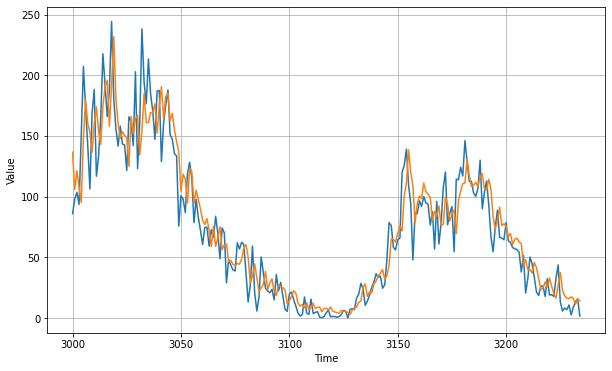

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.110758

range(0, 161)


<Figure size 432x288 with 0 Axes>

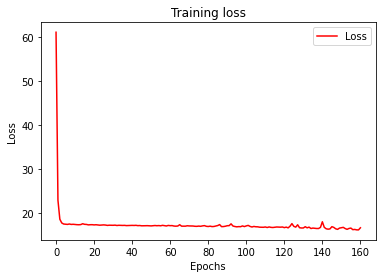

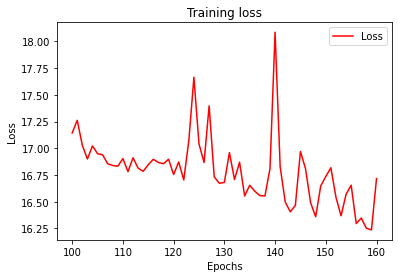

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs
print(epochs)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[100:len(loss)]
zoomed_epochs = range(100,len(loss))


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [20]:
print(rnn_forecast)

[ 1.22618942e+02  9.62122498e+01  1.02783646e+02  9.03051987e+01
  9.33738861e+01  1.31254745e+02  1.68595474e+02  1.51372131e+02
  1.38641800e+02  1.18979553e+02  1.41166824e+02  1.61583298e+02
  1.31939697e+02  1.39929367e+02  1.59651733e+02  1.96349792e+02
  1.81176849e+02  1.38965912e+02  1.73208557e+02  2.16394638e+02
  1.62214249e+02  1.55636734e+02  1.25852592e+02  1.40750977e+02
  1.40418182e+02  1.34370041e+02  1.20320480e+02  1.48569168e+02
  1.54097076e+02  1.39362366e+02  1.73767136e+02  1.18766006e+02
  1.50295670e+02  1.68841980e+02  1.35210876e+02  1.58564453e+02
  1.47938492e+02  1.48842926e+02  1.37266281e+02  1.32022079e+02
  1.48379517e+02  1.55541336e+02  1.38471390e+02  1.40507614e+02
  1.41242828e+02  1.40643906e+02  1.38596329e+02  1.18697617e+02
  1.10070557e+02  1.24575027e+02  8.66789169e+01  8.37541733e+01
  9.93553314e+01  7.53431091e+01  7.73725433e+01  9.47586441e+01
  8.51943817e+01  9.15670471e+01  7.15143433e+01  7.40866165e+01
  6.29043808e+01  6.09048